Here, we plot the score of the logistic model versus the unit Fisher Information.

# Imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from scipy.special import expit

In [2]:
from data_generating_utils import *

## Hyperparams:

In [3]:
population_size = 100_000
number_of_coefficients = 1
true_betas = [1, -1]
sample_size = 1_000
num_iter = 1_000

### for RNG seed:
pop_index = 1
iter_val = 0

In [4]:
rand_generator = np.random.default_rng(seed=333 * pop_index + iter_val)
feature_cols = [f'x_{i}' for i in range(number_of_coefficients)]

# Run:

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.13s/it]


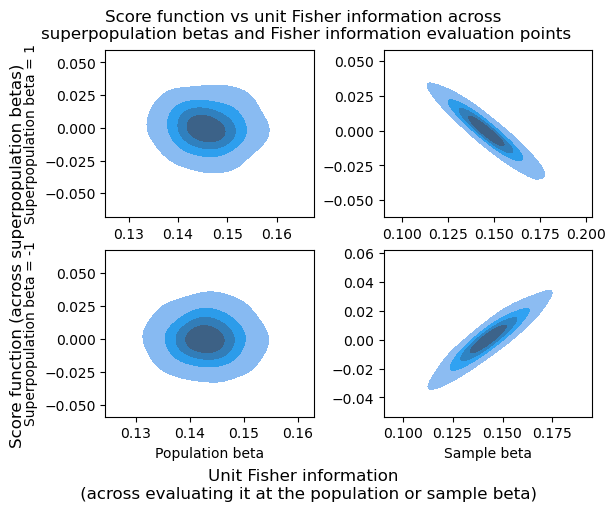

In [7]:
fig, axes = plt.subplots(len(true_betas), 2, 
                         constrained_layout=True, 
                         figsize=(6, 5))

for true_beta_index in trange(len(true_betas)):
    true_beta = true_betas[true_beta_index]
    pop_data = generate_population_data(population_size, number_of_coefficients, rand_generator,
                                    feature_cols = feature_cols, true_beta = true_beta)
    pop_model = sm.Logit(endog = pop_data['y'], exog = pop_data['x_0']).fit(disp=0)
    pop_beta = pop_model.params[0]
    
    pop_data['pop_eta'] = expit(pop_beta * pop_data['x_0'])
    pop_data['pop_score'] = pop_data.eval('x_0 * (y - pop_eta)')
    pop_data['pop_neg_deriv_score'] = pop_data.eval('(x_0 ** 2) * (1 - pop_eta) * pop_eta')

    """
        Plot score vs FI evaluated at the Population:
    """
    ax = axes[true_beta_index][0]
    all_sample_data_for_score = []
    for _ in range(num_iter):
        all_sample_data_for_score.append(pop_data.sample(sample_size)[['pop_score', 'pop_neg_deriv_score']].mean())
    
    
    all_sample_data_for_score = pd.concat(all_sample_data_for_score, axis=1).T
    sns.kdeplot(data = all_sample_data_for_score, x='pop_neg_deriv_score', \
                y = 'pop_score', fill=True, bw_adjust=1.8, levels=5, ax=ax)

    ax.set_ylabel(f"Superpopulation beta = {true_beta}")
    if true_beta_index == len(true_betas) - 1:
        ax.set_xlabel(f"Population beta")            
    else: 
        ax.set_xlabel("")
        
    """
        Plot score vs FI evaluated at the Sample Beta:
    """
    ax = axes[true_beta_index][1]
    all_sample_data_for_score = []
    for _ in range(num_iter):    
        samp_data = pop_data.sample(sample_size).copy()
        samp_model = sm.Logit(endog = samp_data['y'], exog = samp_data['x_0']).fit(disp = 0)
        samp_beta = samp_model.params[0]
        samp_data['eta_sample'] = expit(samp_beta * samp_data['x_0'])
        samp_data['neg_deriv_score_sample'] = samp_data.eval('(x_0 ** 2) * (1 - eta_sample) * eta_sample')
        all_sample_data_for_score.append(
            samp_data[['pop_score', 'pop_neg_deriv_score', 'neg_deriv_score_sample']].mean()
        )


    all_sample_data_for_score = pd.concat(all_sample_data_for_score, axis=1).T

    sns.kdeplot(data = all_sample_data_for_score, x='neg_deriv_score_sample', \
                y = 'pop_score', fill=True, bw_adjust=1.8, levels=5, ax=ax)
    
    ax.set_ylabel("")
    if true_beta_index == len(true_betas) - 1:
        ax.set_xlabel(f"Sample beta")            
    else: 
        ax.set_xlabel("") 

fig.suptitle('Score function vs unit Fisher information across \n' + 
             f'superpopulation betas and Fisher information evaluation points')
fig.supylabel('Score function (across superpopulation betas)')
fig.supxlabel('Unit Fisher information \n (across evaluating it at the ' + \
              'population or sample beta)')

plt.savefig(f'score_vs_unit_fi.png')